# Travel Insurance Prediction

**Table of Contents**<a id='toc0_'></a>    
- 1. [Introduction      ](#toc1_)    
- 2. [Notebook and Data Preparation      ](#toc2_)    
  - 2.1. [Summary on Data Preparation   ](#toc2_1_)    
- 3. [Exploratory Data Analysis      ](#toc3_)    
  - 3.1. [Variable Relationships   ](#toc3_1_)    
  - 3.2. [Feature and Target Relationships   ](#toc3_2_)    
  - 3.3. [Summary on Exploratory Data Analysis   ](#toc3_3_)    
- 4. [Statistical Inference    ](#toc4_)    
  - 4.1. [Categorical Features    ](#toc4_1_)    
  - 4.2. [Numerical Features    ](#toc4_2_)    
  - 4.3. [Summary on Statistical Inference    ](#toc4_3_)    
- 5. [Models for Prediction    ](#toc5_)    
  - 5.1. [Model Training, Selection and Tuning  ](#toc5_1_)    
  - 5.2. [Model Testing  ](#toc5_2_)    
  - 5.3. [Summary on Models ](#toc5_3_)    
- 6. [Recommendations    ](#toc6_)    
- 7. [Suggestions for Improvement    ](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Note that the links in the above table of contents do not work on GitHub or Google Colab. In Google Colab, please use its embedded table of contents.

## 1. <a id='toc1_'></a>Introduction       [&#8593;](#toc0_)

A *Tour & Travels* company is offering travel insurance packages. The company wants to know which customers would be interested to buy it based on their characteristics. The company has offered travel insurance to some of their customers in 2019. The given dataset is based on the outcomes of these offers to almost 2000 customers. The company asks to build a model to predict if the customer will be interested to buy the travel insurance package based on given information.

The provided dataset contains these columns:
* Age  
* Employment Type - Government Sector or Private Sector/Self Employed
* GraduateOrNot 
* AnnualIncome - rounded to nearest 50 thousand Indian Rupees 
* FamilyMembers - number of family members
* ChronicDisease - whether the customer suffers from any chronic disease or not
* FrequentFlyer - whether the customer booked flying tickets at least 4 times in the last 2 years
* EverTravelledAbroad - has the customer ever travelled to a foreign country 
* TravelInsurance - did the customer buy travel insurance during introductory offering in 2019

Different business scenarios are identified:
* The company wants to distinguish customers as good as possible to use customer-specific advertising or content of the travel insurance package. In this case, the model should be accurate.
* The company wants to identify as many potential buyers as possible to offer them travel insurance. In this case, the model should be sensitive. 

The **aim** of this work is to analyze Travel Insurance dataset and provide insights for the company.

The work **objectives** are as follows:
* Explore the dataset to identify relationships between variables;
* Formulate and test hypothesis to compare differences between customers who bought and did not buy travel insurance;
* Build a model to predict whether the customer will be interested in buying travel insurance.

## 2. <a id='toc2_'></a>Notebook and Data Preparation       [&#8593;](#toc0_)

Import libraries for data analysis, visualization and modelling. Set parameters for display.

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats 
import statsmodels.stats.api as sms
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import phik
from helper_functions import preprocessing, custom_model, custom_plots

# Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import (
    mutual_info_classif,
    f_classif,
    chi2,
    SelectKBest,
)
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    GridSearchCV, 
    RandomizedSearchCV,
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)

# Display
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.labelsize": 11,
    "figure.figsize": (7, 4),
    "figure.autolayout": True,  
    "patch.edgecolor": "w",
    "patch.linewidth": 0.5,
    "legend.frameon": False,
    "axes.titlesize": "large",
    "figure.titlesize":   "large", 
}
sns.set_theme(style="whitegrid", rc=custom_params)
pd.set_option("display.precision", 3,"display.max_colwidth", None)
facecolor = sns.color_palette()[0]
emphasiscolor = sns.color_palette()[3]

%matplotlib inline
%config InlineBackend.figure_format = 'png'

Download the dataset from [Kaggle](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data), if it is not already in the `data` folder, and load it. For the method provided below to work, [Kaggle API](https://github.com/Kaggle/kaggle-api) needs to be configured on the system:

In [2]:
dataset_file = "./data/TravelInsurancePrediction.csv"

if not os.path.exists(dataset_file):
    !kaggle datasets download --unzip tejashvi14/travel-insurance-prediction-data -p data
else:
    print("Data already downloaded")

data = pd.read_csv(dataset_file, index_col=0)
data.head()

Data already downloaded


,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


For unification and better visualization, column names and categories are manipulated.

In [3]:
data.rename(
    columns={
        "Employment Type": "Government Employee",
        "GraduateOrNot": "Graduate",
    },
    inplace=True,
)
data.columns = data.columns.str.replace("[\W]", "", regex=True).str.replace(
    "(?<!^)([A-Z])", r" \1", regex=True
)
data.replace(
    {
        "Government Employee": {
            "Government Sector": 1,
            "Private Sector/Self Employed": 0,
        },
    },
    inplace=True,
)
data.replace({"Yes": 1, "No": 0}, inplace=True)
numerical_cols = ["Age", "Annual Income", "Family Members"]
categorical_cols = data.columns.drop(numerical_cols)
data["Annual Income"] = data["Annual Income"] / 1e5  # in 100K of Rupees
data = preprocessing.optimize_dtypes(data)

There are almost 2000 instances in the dataset. Luckily, there are no missing values in any of the columns.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1987 non-null   uint8  
 1   Government Employee    1987 non-null   uint8  
 2   Graduate               1987 non-null   uint8  
 3   Annual Income          1987 non-null   float64
 4   Family Members         1987 non-null   uint8  
 5   Chronic Diseases       1987 non-null   uint8  
 6   Frequent Flyer         1987 non-null   uint8  
 7   Ever Travelled Abroad  1987 non-null   uint8  
 8   Travel Insurance       1987 non-null   uint8  
dtypes: float64(1), uint8(8)
memory usage: 46.6 KB


However, a substantial proportion (37%) of data could be identified as duplicates. They are more common in instances where travel insurance was not bought. Since most of the features are binary categorical, and numerical features are either integers or rounded, it is likely that these duplicates arose naturally. Also, it is possible that duplicates resulted from offering the insurance to the same customer. To retain a representative distribution of data, potential duplicates are kept within dataset.

In [5]:
print("Number of duplicate instances: ", sum(data.duplicated()))
print(
    "Proportion of duplicate instances: ",
    round(sum(data.duplicated()) / data.shape[0], 2),
)
print(
    "Proportion of duplicate instances per Travel Insurance category:\n",
    (data.loc[data.duplicated()]["Travel Insurance"].value_counts())
    / data["Travel Insurance"].value_counts(),
)

Number of duplicate instances:  738
Proportion of duplicate instances:  0.37
Proportion of duplicate instances per Travel Insurance category:
 0    0.40
1    0.32
Name: Travel Insurance, dtype: float64


Categorical features and target are all binary. The proportions of Yes'es and No's are not equal. This means that dataset is imbalanced as there are more instances on customers who did not buy travel insurance.

In [6]:
data[categorical_cols].apply(pd.Series.value_counts).style.background_gradient(
    cmap="Blues", vmin=0, vmax=2000
)

,Government Employee,Graduate,Chronic Diseases,Frequent Flyer,Ever Travelled Abroad,Travel Insurance
0,1417,295,1435,1570,1607,1277
1,570,1692,552,417,380,710


None of the numeric features follow normal distribution. A substantial proportion of customers in the dataset are 28 years old. Most customers report 3 to 7 family members. Also, customers earning more than 1.6 million rupees annually are not common.

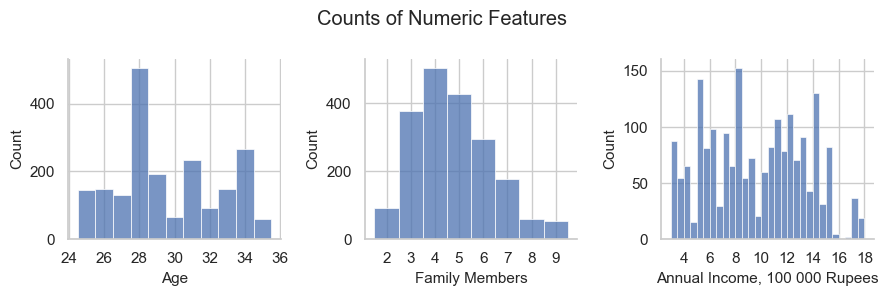

,Age,Annual Income,Family Members
count,1987.000,1987.000,1987.000
mean,29.650,9.328,4.753
std,2.913,3.769,1.610
min,25.000,3.000,2.000
50%,29.000,9.000,5.000
max,35.000,18.000,9.000


In [36]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
sns.histplot(data=data, x="Age", discrete=True, ax=axs[0])
sns.histplot(data=data, x="Family Members", discrete=True, ax=axs[1])
sns.histplot(data=data, x="Annual Income", binwidth=0.5, ax=axs[2])
axs[2].set(xlabel="Annual Income, 100 000 Rupees")
[ax.xaxis.set_major_locator(MaxNLocator(integer=True)) for ax in axs]
fig.suptitle("Counts of Numeric Features")
plt.show()
data[numerical_cols].describe(percentiles=[0.5])

Dataset is split into training and testing sets in a stratified fashion to maintain the same proportion of customers, who bought and did not buy travel insurance.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns="Travel Insurance"),
    data["Travel Insurance"],
    test_size=0.2,
    stratify=data["Travel Insurance"],
    random_state=0,
)
categorical_features = categorical_cols.drop("Travel Insurance").to_list()

### 2.1. <a id='toc2_1_'></a>Summary on Data Preparation    [&#8593;](#toc0_)

1. The provided dataset does not contain missing values.
2. A significant proportion of instances could be considered as duplicates. However, they may also represent the true distribution of data.
3. The dataset has 5 binary categorical features, 3 discrete numerical features and 1 binary target.
4. The dataset is imbalanced in terms of target variable so it is split in training (exploratory) and testing sets in a stratified fashion. 

## 3. <a id='toc3_'></a>Exploratory Data Analysis       [&#8593;](#toc0_)

Exploratory data analysis is performed only on the training set. For visualization purposes, a copy of the training set with binary categorical columns encoded as *No* and *Yes* is used.

In [9]:
data_eda = X_train.copy()
data_eda["Travel Insurance"] = y_train
data_eda_viz = data_eda.copy()
data_eda_viz.replace({1: "Yes", 0: "No"}, inplace=True)
data_eda_viz.head()

,Age,Government Employee,Graduate,Annual Income,Family Members,Chronic Diseases,Frequent Flyer,Ever Travelled Abroad,Travel Insurance
688,33,Yes,Yes,4.0,5,Yes,No,No,No
1676,27,Yes,Yes,10.5,7,No,No,No,Yes
1479,25,No,Yes,14.0,7,No,No,Yes,Yes
581,28,No,Yes,7.0,4,Yes,No,No,No
220,35,No,No,8.0,2,No,No,No,No


### 3.1. <a id='toc3_1_'></a>Variable Relationships    [&#8593;](#toc0_)

The dataset contains variables of mixed types, so $Phi_{K}$ correlation coefficient is used in a correlation matrix. The coefficient is based on several refinements to Pearson’s hypothesis test of independence of two variables. It works consistently between categorical, ordinal and numerical variables, and captures non-linear dependency. The $Phi_{K}$ correlation coefficient reverts to the Pearson correlation coefficient in case of normal distributions.

Based on the correlation matrix, features of Chronic Diseases and Family Members are not correlated with any other features or Travel Insurance target. Graduate feature also is not correlated with Travel Insurance target. Annual Income and Ever Travelled Abroad features are highly correlated. The correlation between these features and the target variable is also moderate.

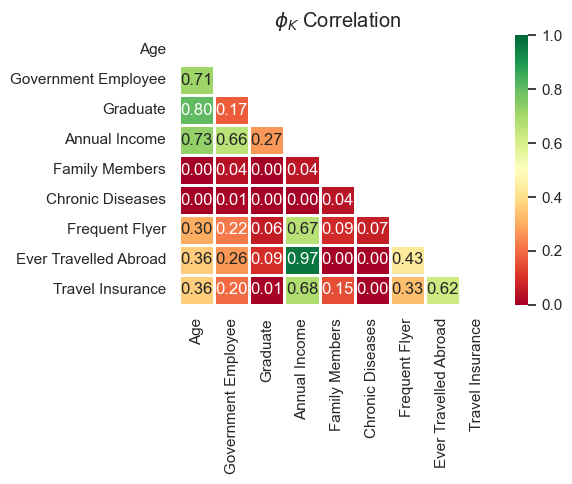

In [10]:
phik_corr = data_eda.phik_matrix(interval_cols=numerical_cols)
mask = np.triu(np.ones_like(phik_corr, dtype=bool))
plt.figure(figsize=(6, 5))
sns.heatmap(
    phik_corr,
    mask=mask,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f",
    vmin=0,
    vmax=1,
    linewidths=1,
)
plt.title("$\phi_K$ Correlation")
plt.grid(False)
plt.show()

In addition, Cramer's V, a measure of association between two nominal variables, is calculated. This measure is based on Pearson's chi-squared statistic and can be used with nominal, ordinal or numerical data types. Cramer's V may be viewed as the association between two variables as a percentage of their maximum possible variation.

The Cramer's V correlation matrix show the same tendencies as $Phi_{K}$ correlation matrix.

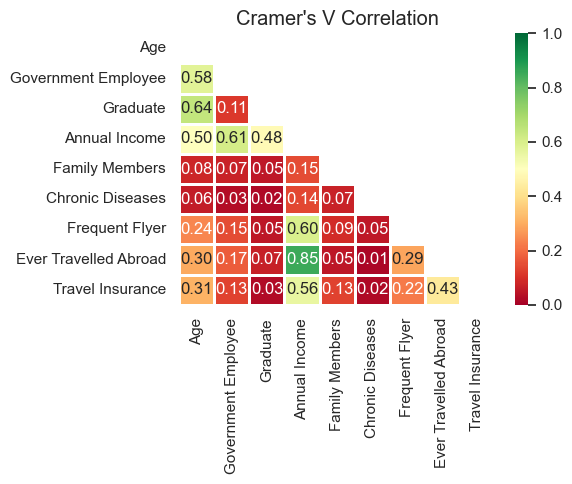

In [11]:
def cramer_corr_fun(x, y):
    CrosstabResult = pd.crosstab(x, y)
    V = stats.contingency.association(CrosstabResult, method="cramer")
    return V


cramer_corr = data_eda.corr(method=cramer_corr_fun)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cramer_corr,
    mask=mask,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f",
    vmin=0,
    vmax=1,
    linewidths=1,
)
plt.title("Cramer's V Correlation")
plt.grid(False)
plt.show()

In the Mosaic plots below, the areas of the rectangular tiles that are available for a combination of categorical variables are proportional to the number of instances that have this combination of variables.

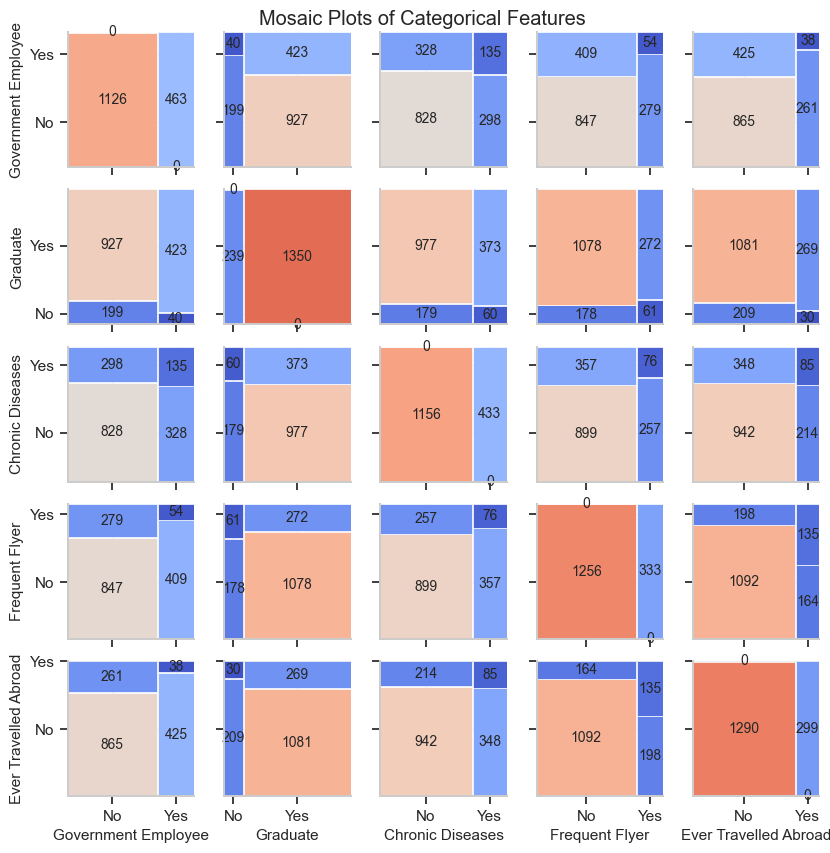

In [12]:
def func_plot_mosaic(x, y, **kwargs):
    ax = plt.gca()
    cross_table = pd.crosstab(columns=y, index=x)
    cross_dict = cross_table.to_dict(orient="index")
    cross_dict_flattened = {
        (index, col): value
        for index, values in cross_dict.items()
        for col, value in values.items()
    }
    labelizer = lambda k: cross_dict_flattened[k]
    total = sum(cross_dict_flattened.values())
    props = {
        key: {"facecolor": cm.coolwarm(value / total)}
        for key, value in cross_dict_flattened.items()
    }
    mosaic(cross_dict_flattened, ax=ax, labelizer=labelizer, properties=props)


g = sns.PairGrid(data_eda_viz, vars=categorical_features, height=1.7)
g.map(func_plot_mosaic)
g.figure.suptitle("Mosaic Plots of Categorical Features", y=1)
plt.show()

None of the numerical features exhibit clear outliers. Family Members feature does not show clear relationship with Annual Income or Age. However, it might be some weak relationship between the latter two. 

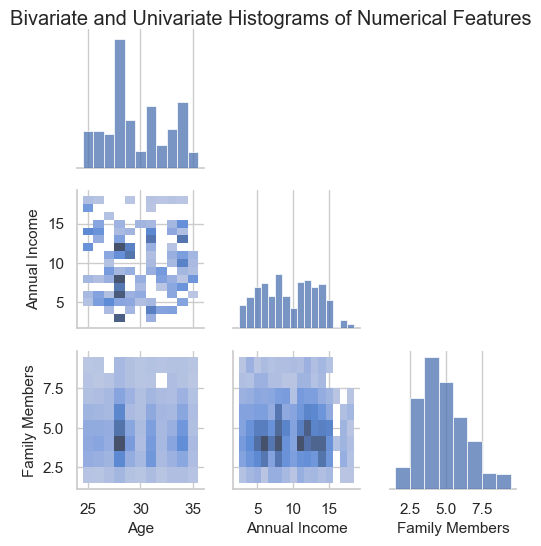

In [13]:
g = sns.PairGrid(data_eda_viz, vars=numerical_cols, height=1.8, corner=True)
g.map_lower(sns.histplot, discrete=True)
g.map_diag(sns.histplot, discrete=True)
g.fig.suptitle(
    "Bivariate and Univariate Histograms of Numerical Features", y=1
)
plt.show()

It is difficult to see any tendencies in proportions of categorical variables regarding numerical variables. However, it seems that higher Annual Income may be related to proportion of Frequent Flyer variable. Lower Annual Income may be related to the proportion of Government Employee variable.

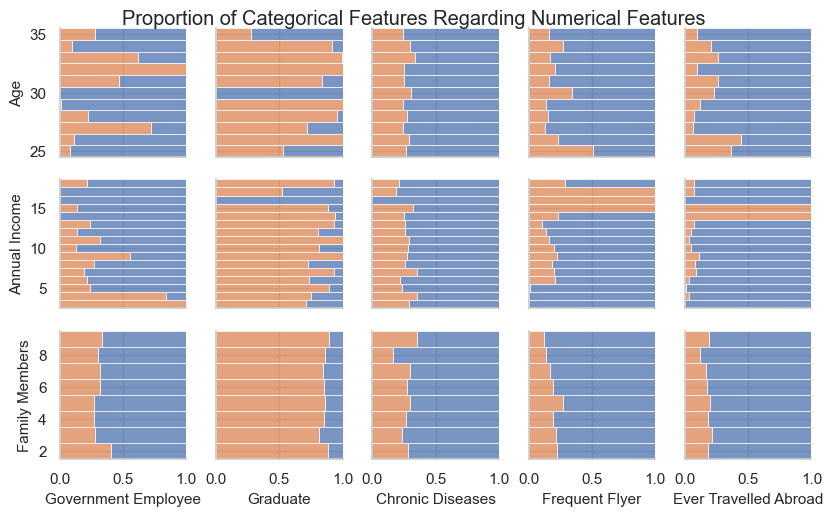

In [14]:
def plot_func(x, y, **kwargs):
    ax = plt.gca()
    sns.histplot(
        y=y,
        hue=x,
        ax=ax,
        stat="proportion",
        multiple="fill",
        hue_order=["No", "Yes"],
        discrete=True,
    )


g = sns.PairGrid(
    data_eda_viz,
    x_vars=categorical_features,
    y_vars=numerical_cols,
    height=1.7,
)
g.map(plot_func)
g.fig.suptitle(
    "Proportion of Categorical Features Regarding Numerical Features", y=1
)
plt.show()

### 3.2. <a id='toc3_2_'></a>Feature and Target Relationships    [&#8593;](#toc0_)

It can be seen that the proportion of travel insurance buying does not depend a lot on graduation or chronic disease status. However, it does seem that customers who are not government employees, are frequent flyers and have travelled abroad tend to buy travel insurance more often.

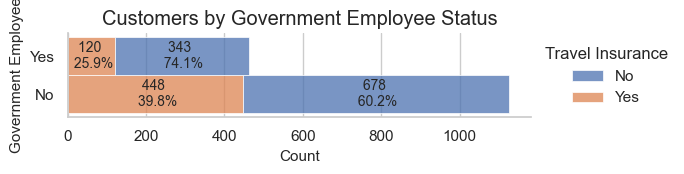

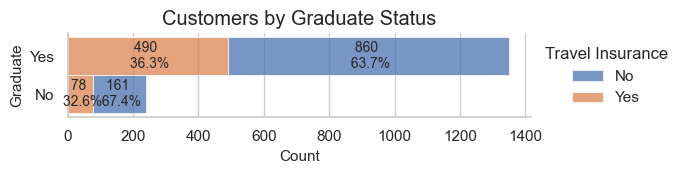

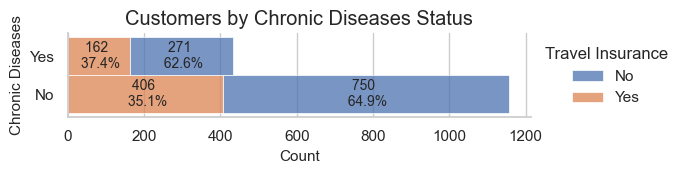

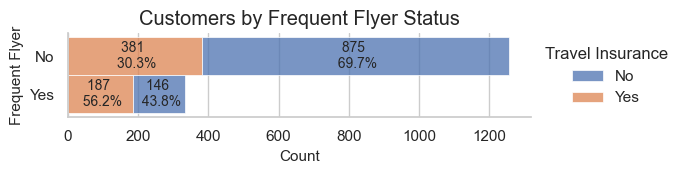

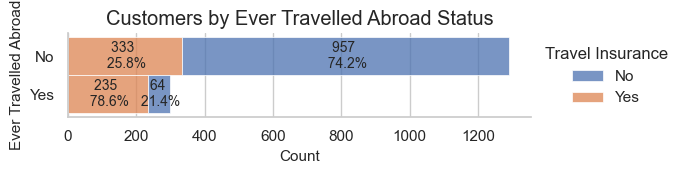

In [15]:
for feature in categorical_features:
    fig = custom_plots.histplots_count_with_percent(
        df=data_eda_viz,
        y=feature,
        hue="Travel Insurance",
        hue_order=["No", "Yes"],
        title=f"Customers by {feature} Status",
    )
    fig.set_figheight(1.9)
    plt.show()

Customers on the lower and higher ends of age tend to buy travel insurance more often as well as those who earn more. Also, it seems that having more family members slightly increases the chances to buy travel insurance.

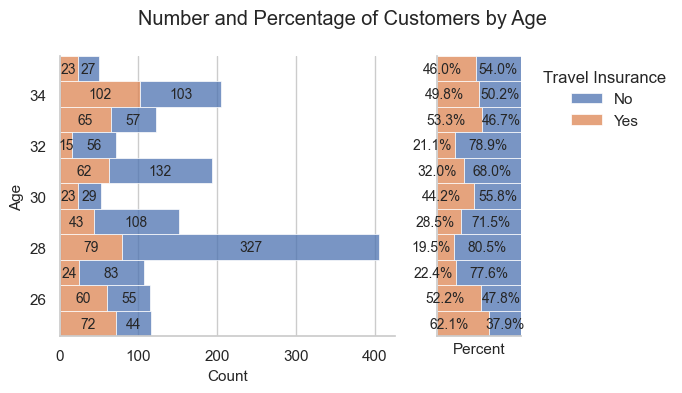

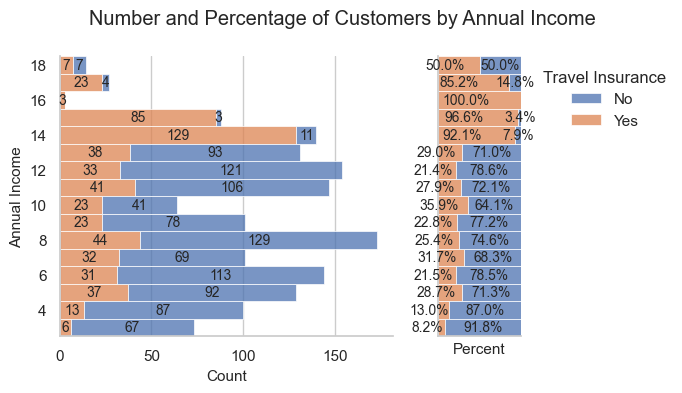

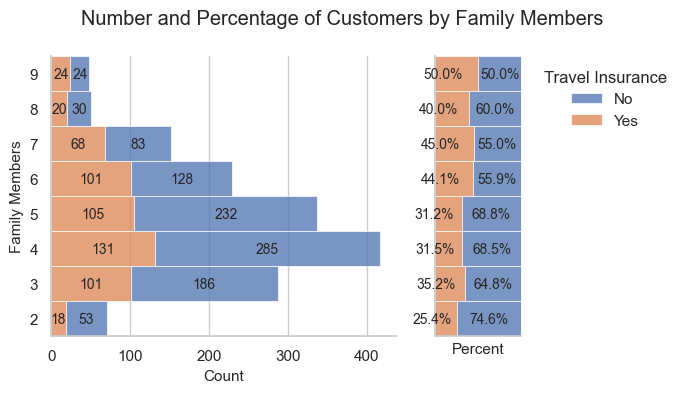

In [16]:
for feature in numerical_cols:
    fig, _ = custom_plots.histplots_count_percent(
        df=data_eda_viz,
        y=feature,
        hue="Travel Insurance",
        hue_order=["No", "Yes"],
        title=f"Number and Percentage of Customers by {feature}",
        discrete=True,
    )
    plt.show()

Random forest tends to prefer numerical features in terms of importance. Annual Income and Ever Travelled Abroad are features related to buying travel insurance based on all metrics. On the other hand, Chronic Diseases and Graduate status seem to be less related to buying travel insurance.

In [17]:
rnd_clf = RandomForestClassifier(
    n_estimators=100, random_state=0, class_weight="balanced"
)
rnd_clf.fit(X_train, y_train)
mi = mutual_info_classif(X_train, y_train, random_state=0)
f_score, _ = f_classif(X_train, y_train)
chi_score, _ = chi2(X_train, y_train)
df = pd.DataFrame(
    {
        "Importance": rnd_clf.feature_importances_,
        "Mutual Information": mi,
        "F Score": f_score,
        "Chi2 Score": chi_score,
    },
    index=X_train.columns,
)
df.style.background_gradient(cmap="PuBu", axis=0).format(precision=3)

,Importance,Mutual Information,F Score,Chi2 Score
Age,0.182,0.029,5.879,1.667
Government Employee,0.023,0.012,27.924,19.470
Graduate,0.019,0.001,1.184,0.178
Annual Income,0.382,0.166,273.681,356.020
Family Members,0.209,0.000,16.127,8.786
Chronic Diseases,0.038,0.012,0.720,0.524
Frequent Flyer,0.038,0.012,80.170,60.398
Ever Travelled Abroad,0.110,0.092,360.928,239.022


### 3.3. <a id='toc3_3_'></a>Summary on Exploratory Data Analysis    [&#8593;](#toc0_)

1. Features of Chronic Diseases and Family Members are not correlated with any other features.
2. Chronic Diseases and Graduate features are not correlated with Travel Insurance target. 
3. Annual Income and Ever Travelled Abroad features are highly correlated. The correlation between these features and target variable is also moderate.
4. The proportion of travel insurance buying does not depend a lot on Graduate or Chronic Diseases features.
5. Customers who are not government employees, are frequent flyers and have travelled abroad tend to buy travel insurance more often.
6. Higher Annual Income may be related to the proportion of Frequent Flyers. Lower Annual Income may be related to the proportion of Government Employees.
7. Customers who earn more tend to buy travel insurance more often.

## 4. <a id='toc4_'></a>Statistical Inference     [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Categorical Features     [&#8593;](#toc0_)

To investigate if categorical features are of importance when predicting if the customer will buy an insurance or not, proportions of feature presence in two customer categories are compared. The **null hypothesis** is raised that the proportions are equal for customers who bought and did not buy travel insurance. The **alternative hypothesis** is that the proportions are not equal. **Population** here are customers of Tour & Travels Company. **Parameter of interest** is difference in proportions. In forming confidence intervals and testing the hypotheses, two independent random samples are assumed. Since the sample sizes are big enough, the distribution of the estimate of the parameter of interest is assumed to be normal. The significance level of $\alpha=0.05$ is used to calculate the confidence interval and perform a z-test.

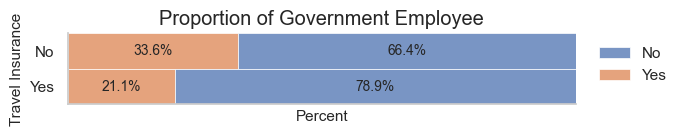

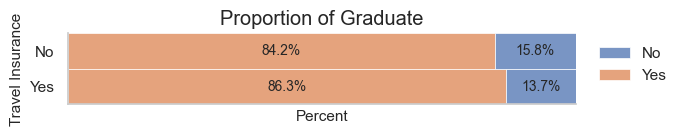

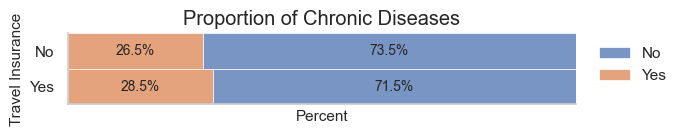

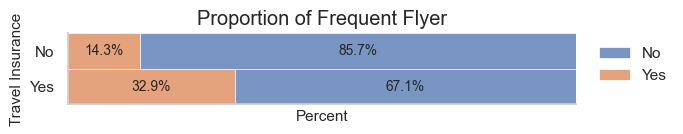

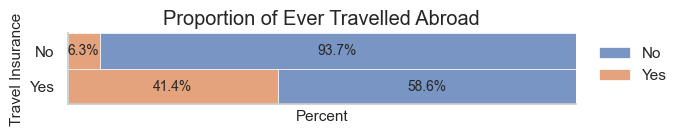

,"of Customers w/o Insurance, %","of Customers with Insurance, %","Difference, %",z-test statistic,p-value,"95% CI, %",Reject H0
Government Employee,33.6,21.1,12.5,5.240,0.000,"(7.9, 16.8)",Yes
Graduate,84.2,86.3,-2.0,-1.088,0.277,"(-5.5, 1.7)",No
Chronic Diseases,26.5,28.5,-2.0,-0.849,0.396,"(-6.6, 2.5)",No
Frequent Flyer,14.3,32.9,-18.6,-8.739,0.000,"(-23.1, -14.2)",Yes
Ever Travelled Abroad,6.3,41.4,-35.1,-17.153,0.000,"(-39.4, -30.8)",Yes


In [18]:
testing_cat = pd.DataFrame(index=categorical_features)
alpha = 0.05
intervals = []
for feature in categorical_features:
    fig, _ = custom_plots.histplot_filled_percent(
        df=data_eda_viz,
        y="Travel Insurance",
        hue=feature,
        hue_order=["No", "Yes"],
        title=f"Proportion of {feature}",
        ylabel="Travel Insurance",
    )
    fig.set_figheight(1.5)
    plt.show()
    df = data_eda_viz.groupby(["Travel Insurance"])[feature].value_counts()
    count0 = df.loc[("No", "Yes")]
    n0 = count0 + df.loc[("No", "No")]
    p0 = count0 / n0 * 100
    count1 = df.loc[("Yes", "Yes")]
    n1 = count1 + df.loc[("Yes", "No")]
    p1 = count1 / n1 * 100
    test_stat, pval = sms.test_proportions_2indep(
        count0, n0, count1, n1, value=0, method="score", return_results=False
    )
    ci = sms.confint_proportions_2indep(
        count0, n0, count1, n1, compare="diff", alpha=alpha
    )
    intervals.append(tuple([round(x * 100, 1) for x in ci]))
    testing_cat.loc[feature, "of Customers w/o Insurance, %"] = round(p0, 1)
    testing_cat.loc[feature, "of Customers with Insurance, %"] = round(p1, 1)
    testing_cat.loc[feature, "Difference, %"] = round(p0 - p1, 1)
    testing_cat.loc[feature, "z-test statistic"] = test_stat
    testing_cat.loc[feature, "p-value"] = round(pval, 3)
testing_cat["95% CI, %"] = intervals
testing_cat["Reject H0"] = testing_cat["p-value"].apply(
    lambda x: "Yes" if x < alpha else "No"
)
testing_cat

### 4.2. <a id='toc4_2_'></a>Numerical Features     [&#8593;](#toc0_)

To investigate if numerical features are of importance when predicting if the customer will buy an insurance or not, means in two customer categories are compared. The **null hypothesis** is raised that the means of numerical features are equal for customers who bought and did not buy travel insurance. The **alternative hypothesis** is that the means are not equal. **Population** here are customers of Tour & Travels Company. **Parameter of interest** is difference in numerical feature means. In forming confidence intervals and testing the hypotheses, two independent random samples are assumed. Since the sample sizes are big enough, the distribution of the estimate of the parameter of interest is assumed to be normal. The significance level of $\alpha=0.05$ is used to calculate the confidence interval and perform a t-test. To support statistical testing, a permutation test is performed, which do not assume any particular distribution. 

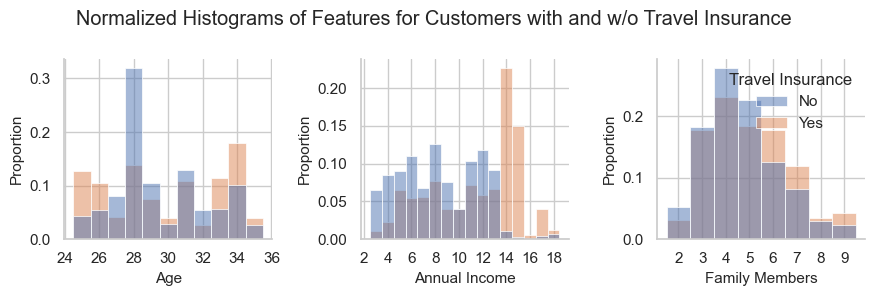

,Mean of Customers w/o Insurance,Mean of Customers with Insurance,Difference,t-test statistic,p-value,Permutation Difference,Permutation p-value,95% CI,Reject H0
Age,29.52,29.89,-0.37,-2.274,0.023,-0.37,0.017,"(-0.69, -0.05)",Yes
Annual Income,8.19,11.19,-3.00,-15.921,0.000,-3.01,0.000,"(-3.38, -2.64)",Yes
Family Members,4.67,5.01,-0.34,-3.926,0.000,-0.34,0.000,"(-0.51, -0.17)",Yes


In [33]:
def statistic(x, y):
    return np.mean(x) - np.mean(y)


testing_num = pd.DataFrame(index=numerical_cols)
alpha = 0.05
usevar = "unequal"
intervals = []
for feature in numerical_cols:
    y0 = data_eda_viz.loc[data_eda_viz["Travel Insurance"] == "No", feature]
    y1 = data_eda_viz.loc[data_eda_viz["Travel Insurance"] == "Yes", feature]
    mean0 = round(np.mean(y0), 2)
    mean1 = round(np.mean(y1), 2)
    cm = sms.CompareMeans(sms.DescrStatsW(y0), sms.DescrStatsW(y1))
    ci = cm.tconfint_diff(usevar=usevar, alpha=alpha)
    intervals.append(tuple([round(x, 2) for x in ci]))
    test_stat, pval, _ = cm.ttest_ind(usevar=usevar)
    testing_num.loc[feature, "Mean of Customers w/o Insurance"] = mean0
    testing_num.loc[feature, "Mean of Customers with Insurance"] = mean1
    testing_num.loc[feature, "Difference"] = mean0 - mean1
    testing_num.loc[feature, "t-test statistic"] = test_stat
    testing_num.loc[feature, "p-value"] = round(pval, 3)
    res = stats.permutation_test((y0, y1), statistic)
    testing_num.loc[feature, "Permutation Difference"] = round(
        res.statistic, 2
    )
    testing_num.loc[feature, "Permutation p-value"] = round(res.pvalue, 3)
testing_num["95% CI"] = intervals
testing_num["Reject H0"] = testing_num["p-value"].apply(
    lambda x: "Yes" if x < alpha else "No"
)
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
show_legend = False
for idx, col in enumerate(numerical_cols):
    if idx == 2:
        show_legend = True
    ax = sns.histplot(
        data=data_eda_viz,
        discrete=True,
        stat="proportion",
        common_norm=False,
        x=col,
        hue="Travel Insurance",
        ax=axes[idx],
        legend=show_legend,
    )
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle(
    "Normalized Histograms of Features for Customers with and w/o Travel"
    " Insurance"
)
plt.show()
testing_num

### 4.3. <a id='toc4_3_'></a>Summary on Statistical Inference     [&#8593;](#toc0_)

These insights for customers who bought and did not buy travel insurance are provided with 95% confidence level:
1. The proportions of government employees are significantly different. There are more government employees among customers who did not buy travel insurance. 
2. The proportions of graduates are not significantly different. 
3. The proportions of those with chronic diseases are not significantly different.
4. The proportions of frequent flyers are significantly different. There are more frequent flyers among customers who did buy travel insurance. 
5. The proportions of those who ever traveled abroad are significantly different. There are more of those who ever traveled abroad among customers who did buy travel insurance. 
6. The average age is significantly different. However, it is only slightly higher among customers who did buy travel insurance. 
7. The average annual income is significantly different. It is higher among customers who did buy travel insurance. 
8. The average number of family members is significantly different. However, it is only slightly higher among customers who did buy travel insurance. 

## 5. <a id='toc5_'></a>Models for Prediction     [&#8593;](#toc0_)

### 5.1. <a id='toc5_1_'></a>Model Training, Selection and Tuning   [&#8593;](#toc0_)

To begin with, a number of untuned algorithms are cross-validated on the training set. Where possible, data imbalance is addressed with class weighting.

In [20]:
classifiers = [
    "Dummy",
    "Logistic Regression",
    "Naive Bayes",
    "KNN",
    "Decision Tree",
    "Linear SVM",
    "Poly SVM",
    "Radial SVM",
]
models = [
    DummyClassifier(strategy="stratified"),
    LogisticRegression(class_weight="balanced"),
    GaussianNB(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(class_weight="balanced", random_state=0),
    SVC(kernel="linear", class_weight="balanced", probability=True),
    SVC(kernel="poly", degree=2, class_weight="balanced", probability=True),
    SVC(kernel="rbf", class_weight="balanced", probability=True),
]
models = [make_pipeline(StandardScaler(), model) for model in models]
fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
custom_model.cv_score_binary_classifiers(
    classifiers, models, fold=fold, X=X_train, y=y_train
)

,AUC,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta
Dummy,0.506,0.359,0.361,0.544,0.503,0.360,0.359
Logistic Regression,0.761,0.622,0.629,0.733,0.708,0.624,0.623
Naive Bayes,0.743,0.500,0.700,0.745,0.690,0.583,0.530
KNN,0.768,0.592,0.770,0.790,0.746,0.669,0.620
Decision Tree,0.728,0.655,0.625,0.736,0.718,0.639,0.648
Linear SVM,0.753,0.467,0.735,0.746,0.684,0.564,0.501
Poly SVM,0.778,0.574,0.724,0.770,0.726,0.640,0.599
Radial SVM,0.797,0.604,0.735,0.780,0.741,0.663,0.626


Out of the tested models, K-Nearest Neighbors (KNN) and Support Vector Machine (SVM) with radial basis function kernel algorithms seem as the best candidates for accurate model, and decision tree - for sensitive model. These algorithms are tuned for high balanced accuracy (KNN and SVM) and recall (decision tree) using randomized and grid search. Top features are selected based on chi-square score. For KNN and SVM algorithms, features are scaled using either standard or min-max scalers. 

KNN algorithm achieving highest balanced accuracy is based on 5 neighbors obtained using Manhattan distance and weighted uniformly. The classifier uses 6 min-max-scaled features.

In [21]:
pipe_knn = Pipeline(
    [
        ("selector", SelectKBest(chi2)),
        ("scaler", StandardScaler()),
        ("classifier", KNeighborsClassifier()),
    ]
)
params_knn_dist = {
    "selector__k": list(range(3, 9)),
    "scaler": [StandardScaler(), MinMaxScaler()],
    "classifier__n_neighbors": stats.randint(1, 15),
    "classifier__weights": ["uniform", "distance"],
    "classifier__metric": ["manhattan", "euclidean", "hamming"],
}
random_grid = RandomizedSearchCV(
    pipe_knn,
    params_knn_dist,
    cv=fold,
    scoring="balanced_accuracy",
    random_state=0,
    n_iter=100,
).fit(X_train, y_train)
print("Best random KNN parameters:\n", random_grid.best_params_)
print("Balanced accuracy: ", round(random_grid.best_score_, 3))

Best random KNN parameters:
 {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 6, 'classifier__weights': 'uniform', 'scaler': MinMaxScaler(), 'selector__k': 6}
Balanced accuracy:  0.75


In [22]:
pipe_knn = Pipeline(
    [
        ("selector", SelectKBest(chi2, k=6)),
        ("scaler", MinMaxScaler()),
        (
            "classifier",
            KNeighborsClassifier(metric="manhattan", weights="uniform"),
        ),
    ]
)
params_knn = {"classifier__n_neighbors": [4, 5, 6, 7, 8]}
grid = GridSearchCV(
    pipe_knn, params_knn, cv=fold, scoring="balanced_accuracy"
).fit(X_train, y_train)
print("Best KNN parameters:\n", grid.best_params_)
print("Balanced accuracy: ", round(grid.best_score_, 3))
best_knn = grid.best_estimator_
print("Best KNN classifier:", best_knn)

Best KNN parameters:
 {'classifier__n_neighbors': 5}
Balanced accuracy:  0.756
Best KNN classifier: Pipeline(steps=[('selector',
                 SelectKBest(k=6,
                             score_func=<function chi2 at 0x0000015AB3C82C20>)),
                ('scaler', MinMaxScaler()),
                ('classifier', KNeighborsClassifier(metric='manhattan'))])


Radial SVM algorithm with C parameter of 3.75 and gamma parameter of 0.2 achieves highest balanced accuracy. The classifier uses 6 standard-scaled features.

In [23]:
pipe_svm = Pipeline(
    [
        ("selector", SelectKBest(chi2)),
        ("scaler", StandardScaler()),
        ("classifier", SVC(kernel="rbf", class_weight="balanced")),
    ]
)
params_svm_dist = {
    "selector__k": list(range(3, 9)),
    "scaler": [StandardScaler(), MinMaxScaler()],
    "classifier__C": stats.uniform(0.1, 5),
    "classifier__gamma": stats.uniform(0.01, 1),
}
random_grid = RandomizedSearchCV(
    pipe_svm,
    params_svm_dist,
    cv=fold,
    scoring="balanced_accuracy",
    random_state=0,
    n_iter=100,
).fit(X_train, y_train)
print("Best random SVM parameters:\n", random_grid.best_params_)
print("Balanced accuracy: ", round(random_grid.best_score_, 3))

Best random SVM parameters:
 {'classifier__C': 3.3657001789896883, 'classifier__gamma': 0.18090958513604516, 'scaler': StandardScaler(), 'selector__k': 6}
Balanced accuracy:  0.76


In [24]:
pipe_svm = Pipeline(
    [
        ("selector", SelectKBest(chi2, k=6)),
        ("scaler", StandardScaler()),
        (
            "classifier",
            SVC(kernel="rbf", class_weight="balanced", probability=True),
        ),
    ]
)
params_svm = {
    "classifier__C": [3, 3.25, 3.5, 3.75, 4],
    "classifier__gamma": [0.1, 0.15, 0.2, 0.25, 0.3],
}
grid = GridSearchCV(
    pipe_svm, params_svm, cv=fold, scoring="balanced_accuracy"
).fit(X_train, y_train)
print("Best SVM parameters:\n", grid.best_params_)
print("Balanced accuracy: ", round(grid.best_score_, 3))
best_svm = grid.best_estimator_
print("Best SVM classifier:", best_svm)

Best SVM parameters:
 {'classifier__C': 3.75, 'classifier__gamma': 0.2}
Balanced accuracy:  0.766
Best SVM classifier: Pipeline(steps=[('selector',
                 SelectKBest(k=6,
                             score_func=<function chi2 at 0x0000015AB3C82C20>)),
                ('scaler', StandardScaler()),
                ('classifier',
                 SVC(C=3.75, class_weight='balanced', gamma=0.2,
                     probability=True))])


Decision tree with Gini splitting criterion, maximum depth of 15, maximum leaf nodes of 50, and minimum samples per leaf of 11, achieves highest recall. The classifier uses 7 features.

In [25]:
pipe_tree = Pipeline(
    [
        ("selector", SelectKBest(chi2)),
        (
            "classifier",
            DecisionTreeClassifier(class_weight="balanced", random_state=0),
        ),
    ]
)
params_tree_dist = {
    "selector__k": list(range(3, 9)),
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_depth": stats.randint(2, 50),
    "classifier__min_samples_leaf": stats.randint(2, 50),
    "classifier__max_leaf_nodes": stats.randint(2, 50),
}
random_grid = RandomizedSearchCV(
    pipe_tree,
    params_tree_dist,
    cv=fold,
    scoring="recall",
    random_state=0,
    n_iter=100,
).fit(X_train, y_train)
print("Best random tree parameters:\n", random_grid.best_params_)
print("Recall: ", round(random_grid.best_score_, 3))

Best random tree parameters:
 {'classifier__criterion': 'gini', 'classifier__max_depth': 37, 'classifier__max_leaf_nodes': 44, 'classifier__min_samples_leaf': 11, 'selector__k': 7}
Recall:  0.681


In [26]:
pipe_tree = Pipeline(
    [
        ("selector", SelectKBest(chi2, k=7)),
        (
            "classifier",
            DecisionTreeClassifier(
                class_weight="balanced", random_state=0, criterion="gini"
            ),
        ),
    ]
)
params_tree = {
    "classifier__max_depth": [10, 15, 20, 25, 30, 35, 40, 45],
    "classifier__min_samples_leaf": [9, 10, 11, 12, 13],
    "classifier__max_leaf_nodes": [40, 45, 50],
}
grid = GridSearchCV(pipe_tree, params_tree, cv=fold, scoring="recall").fit(
    X_train, y_train
)
print("Best tree parameters:\n", grid.best_params_)
print("Recall: ", round(grid.best_score_, 3))
best_tree = grid.best_estimator_
print("Best tree classifier:", best_tree)

Best tree parameters:
 {'classifier__max_depth': 15, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 11}
Recall:  0.687
Best tree classifier: Pipeline(steps=[('selector',
                 SelectKBest(k=7,
                             score_func=<function chi2 at 0x0000015AB3C82C20>)),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=15,
                                        max_leaf_nodes=50, min_samples_leaf=11,
                                        random_state=0))])


The following are the metrics of all tuned classifiers and their soft-voting ensemble. SVM outperforms KNN in all metrics and it should be selected as an accurate single model. However, if improving accuracy is that important, voting ensemble could be used. Decision tree might be selected as a sensitive model. 

In [27]:
classifiers = [
    "Best SVM",
    "Best KNN",
    "Best Decision Tree",
    "Voting",
]
vote = VotingClassifier(
    estimators=[("KNN", best_knn), ("SVM", best_svm), ("tree", best_tree)],
    voting="soft",
)
models = [
    best_svm,
    best_knn,
    best_tree,
    vote,
]
custom_model.cv_score_binary_classifiers(
    classifiers, models, fold=fold, X=X_train, y=y_train
)

,AUC,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta
Best SVM,0.784,0.607,0.820,0.811,0.766,0.697,0.640
Best KNN,0.765,0.606,0.782,0.799,0.756,0.682,0.634
Best Decision Tree,0.813,0.687,0.693,0.779,0.759,0.689,0.688
Voting,0.795,0.600,0.863,0.822,0.773,0.706,0.638


Various untuned ensemble models are also tried. Here, gradient boosting algorithm is able to reach the same balanced accuracy as voting ensemble of tuned models. However, at the expense of recall.

In [28]:
ensemble_classifiers = [
    "Random Forest",
    "Extra Trees",
    "Bagging",
    "AdaBoost",
    "Gradient Boosting",
]
ensemble_models = [
    RandomForestClassifier(class_weight="balanced", random_state=0),
    ExtraTreesClassifier(class_weight="balanced", random_state=0),
    BaggingClassifier(random_state=0),
    AdaBoostClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
]
custom_model.cv_score_binary_classifiers(
    ensemble_classifiers, ensemble_models, fold=fold, X=X_train, y=y_train
)

,AUC,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta
Random Forest,0.791,0.643,0.699,0.773,0.744,0.669,0.653
Extra Trees,0.763,0.646,0.661,0.755,0.731,0.653,0.649
Bagging,0.793,0.636,0.709,0.777,0.745,0.670,0.649
AdaBoost,0.794,0.519,0.904,0.808,0.744,0.659,0.567
Gradient Boosting,0.806,0.581,0.909,0.829,0.774,0.708,0.626


### 5.2. <a id='toc5_2_'></a>Model Testing   [&#8593;](#toc0_)

The performance of the selected models on the training set is slightly better compared to cross-validation. Decision tree achieves higher recall but with the expense of a much lower precision as indicated with a high number of false positives.

,AUC,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta
Best SVM,0.843,0.632,0.867,0.834,0.789,0.731,0.668
Best Decision Tree,0.877,0.708,0.770,0.820,0.795,0.738,0.719
Voting,0.902,0.632,0.904,0.845,0.797,0.744,0.673


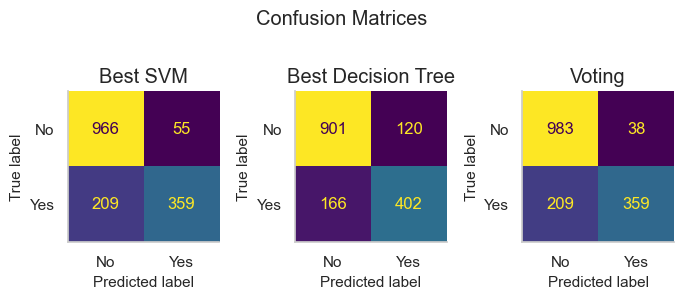

In [29]:
classifiers.remove("Best KNN")
vote.fit(X_train, y_train)
models = [
    best_svm,
    best_tree,
    vote,
]
fig = custom_model.score_binary_fitted_classifiers(
    classifiers, models, X=X_train, y=y_train, labels=["No", "Yes"]
)
fig.set_figheight(3)
plt.show()

The performance of the models on the test set is worse than on the training set, but comparable to cross-validation. Balanced accuracy of 78% is achieved by SVM and voting classifiers, and their recall is 61% and 60%, respectively. Decision tree achieves recall of 62%, which is only slightly better than other classifiers and substantially lower than that achieved during cross-validation. This indicates that the decision tree might have been overfitted to positive classes during training. Since it performs worse on other metrics, SVM and voting algorithms may be preferred as overall better classifiers. If a slight improvement in a specific metric is not that important, SVM could be suggested over voting classifier due to lower complexity.

,AUC,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta
Best SVM,0.779,0.606,0.878,0.829,0.779,0.717,0.646
Best Decision Tree,0.807,0.620,0.710,0.774,0.740,0.662,0.636
Voting,0.786,0.599,0.914,0.837,0.784,0.723,0.643


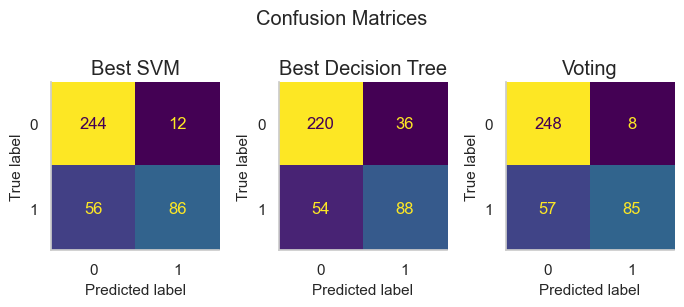

In [30]:
fig = custom_model.score_binary_fitted_classifiers(
    classifiers, models, X=X_test, y=y_test
)
fig.set_figheight(3)
plt.show()

### 5.3. <a id='toc5_3_'></a>Summary on Models  [&#8593;](#toc0_)

1. Out of various untuned classification algorithms, KNN, SVM and decision tree showed the most promising results in terms of balanced accuracy and recall (decision tree).
2. Random and grid search enable acceleration of model parameter tuning.
3. Voting ensemble of tuned models improve overall classification performance.
4. Decision tree might have overfitted to positive instances during training, which resulted in poorer recall on testing set.
5. Radial SVM or voting ensemble could be used for this particular business task of travel insurance prediction. However, if slight improvement in the performance is not that important, SMV could be selected over voting ensemble.

## 6. <a id='toc6_'></a>Recommendations     [&#8593;](#toc0_)

Based on the analysis of the provided Travel Insurance dataset, the following recommendations could be useful:
1. The most important customer characteristics showing the willingness to buy travel insurance are annual income and having travelled abroad.
2. Characteristics about chronic diseases and graduation status seem unrelated to customer willingness to buy travel insurance.
3. Average age and number of family members differs slightly between customers who bought and did not buy travel insurance, but they are not the determining characteristics.
4. Customers who are not government employees, are frequent flyers and have travelled abroad tend to buy travel insurance substantially more often.
5. Depending on the business goal, different models can be considered to achieve high sensitivity or accuracy for predicting if the customer will be interested in buying the travel insurance.
6. SVM achieving balanced accuracy of 78% and recall of 61% could be used as the overall classifier for the current prediction task.

## 7. <a id='toc7_'></a>Suggestions for Improvement     [&#8593;](#toc0_)

The analysis of the Travel Insurance dataset can be improved:
* More information on sampling procedure could be obtained to back up random sampling assumption.
* More algorithms can be tuned to select the best ones for predictions.
* Ways to improve prediction sensitivity could be investigated.
* Probability thresholds could be tuned to achieve the desirable precision-recall trade-off.